# 1. Weisfeiler Lehman:
### 1.1. Initialize graphs as the following image:
![image info](./data/graph_1.png)
### 1.2. Compute WL to compare 2 above graphs without labels.
### 1.3. Compute WL to compare 2 above graphs with node labels.
### 1.4. Compute WL to compare 2 above graphs with edge labels.
### 1.5. Compute 3-WL to compare 2 above graphs without labels.

In [72]:
!pip install networkx pandas numpy matplotlib grakel

import networkx as nx
import numpy as np
from networkx.algorithms import isomorphism
import matplotlib.pyplot as plt
import copy
import pprint
import itertools
import hashlib
from collections import Counter
from grakel.utils import graph_from_networkx
from grakel import GraphKernel

In [73]:
# 1.1 Initialize graphs as the following image

G1 = nx.Graph()
G1.add_edges_from(
    [
        (1, 2, {"label": "Friendship"}),
        (1, 3, {"label": "Friendship"}),
        (1, 4, {"label": "Friendship"}),
        (3, 4, {"label": "Friendship"}),
    ]
)
G1_node_attributes = {
    1: "Thomas",
    2: "Dolores",
    3: "Jose",
    4: "Jack",
}
# Set node labels by using node attributes
nx.set_node_attributes(G1, G1_node_attributes, name="label")

G2 = nx.Graph()
G2.add_edges_from(
    [
        (5, 6, {"label": "Friendship"}),
        (5, 8, {"label": "Friendship"}),
        (5, 7, {"label": "Friendship"}),
        (6, 8, {"label": "Friendship"}),
    ]
)
G2_node_attributes = {
    5: "Ming",
    6: "Amy",
    7: "Wyatt",
    8: "Emily",
}

# Set node labels by using node attributes
nx.set_node_attributes(G2, G2_node_attributes, name="label")

{1: 'Thomas', 2: 'Dolores', 3: 'Jose', 4: 'Jack'}


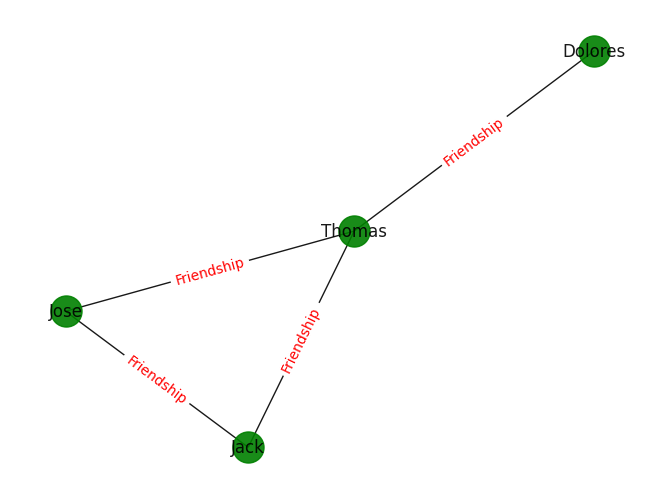

In [74]:
def draw_graph_with_labels(G, label='label'):
    labels = dict()
    names = nx.get_node_attributes(G, label)
    print(names)
    for node in G.nodes:
        labels[node] = f"{names[node]}"
    pos = nx.spring_layout(G)
    plt.figure()
    nx.draw(
        G, pos, edge_color='black', width=1, linewidths=1,
        node_size=500, node_color='green', alpha=0.9,
        labels=labels
    )
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=nx.get_edge_attributes(G, "label"),
        font_color='red'
    )
    plt.axis('off')
    plt.show()
    
draw_graph_with_labels(G1)

{5: 'Ming', 6: 'Amy', 8: 'Emily', 7: 'Wyatt'}


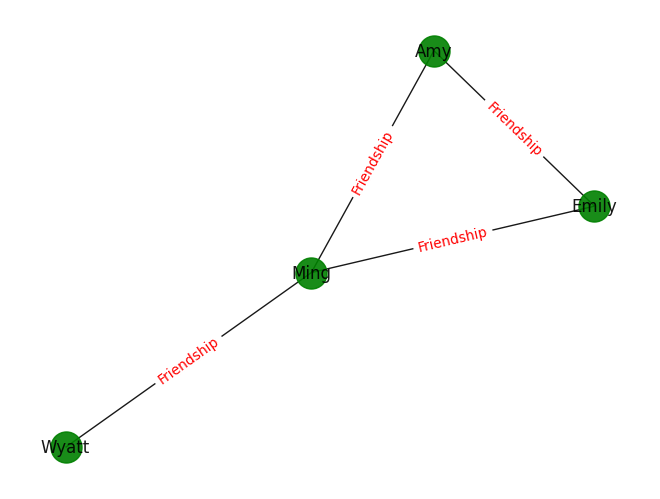

In [75]:
draw_graph_with_labels(G2)

In [76]:
# 1.2. Compute WL to compare 2 above graphs without labels.
g1_hash = nx.weisfeiler_lehman_graph_hash(G1)
g2_hash = nx.weisfeiler_lehman_graph_hash(G2)

# g1_hash and g2_hash are equal when they are isomorphic
print(f"First  graph hash: {g1_hash}")
print(f"Second graph hash: {g2_hash}")
print(f"Checking graph isomorphic: {g1_hash==g2_hash}")

First  graph hash: 7bc4dde9a09d0b94c5097b219891d81a
Second graph hash: 7bc4dde9a09d0b94c5097b219891d81a
Checking graph isomorphic: True


In [77]:
# 1.3. Compute WL to compare 2 above graphs with node labels.
g1_hash = nx.weisfeiler_lehman_graph_hash(G1, node_attr="label")
g2_hash = nx.weisfeiler_lehman_graph_hash(G2, node_attr="label")

# g1_hash and g2_hash are equal when they are isomorphic
print(f"First  graph hash: {g1_hash}")
print(f"Second graph hash: {g2_hash}")
print(f"Checking graph isomorphic: {g1_hash==g2_hash}")

First  graph hash: 892373472f0ae7378ef7283f2904a750
Second graph hash: 22dbf2634b618d4b100ee18a1cbbb40f
Checking graph isomorphic: False


In [78]:
# 1.5. Compute 3-WL to compare 2 above graphs without labels.

# A base function to calculate WL
def compute_base_WL(graph, k, verbose, n_set, initial_colors_func, find_neighbors_func):    
    G, n = n_set(graph)
    colors = initial_colors_func(n)
    old_colors = copy.deepcopy(colors)
    
    for i in range(len(n)):
        for node in n:
            neigh_colors = "".join([colors[i][0] for i in find_neighbors_func(G, n, node)])
            colors[node].extend([neigh_colors])
            colors[node].sort()
            
        # Update with the hash
        colors = {i: [hashlib.sha224("".join(colors[i]).encode('utf-8')).hexdigest()] for i in colors}
        
        if list(Counter([item for sublist in colors.values() for item in sublist]).values()) == list(Counter([item for sublist in old_colors.values() for item in sublist]).values()) and i != 0:
            if verbose:
                print(f'Converged at iteration {i}!')
            break
        
        old_colors = copy.deepcopy(colors)
    canonical_form = sorted(Counter([item for sublist in colors.values() for item in sublist]).items())
    
    if verbose:
        print(f'Canonical Form Found: \n {canonical_form} \n')
        
    return canonical_form

def kWL(G, k, verbose=False):
    def n_set(G):
        G = nx.convert_node_labels_to_integers(G)
        V = list(G.nodes())
        
        # Considering node with k-tuples of nodes
        V_k = [comb for comb in itertools.combinations(V, k)]
        return G, V_k

    def set_initial_colors(n):
        return {i: [hashlib.sha224(str(i).encode('utf-8')).hexdigest()] for i in n}

    # Find k-hop neighbors
    def find_neighbors(G, V_k, node):
        return [n for n in V_k if len(set(n) - set(V_k[V_k.index(node)])) == 1]

    return compute_base_WL(G, k, verbose, n_set, set_initial_colors, find_neighbors)

# Run with k=3
k=3
g1_hash = kWL(G1, k)
g2_hash = kWL(G2, k)

print(f"Checking graph isomorphic: {g1_hash==g2_hash}")

Checking graph isomorphic: True


# 2. Other methods:
### 2.1. Create graphs as the following image:
![image info](./data/graph_2.png)
### 2.2. Using shortest path kernel to compare 2 above graphs.
### 2.3. Using pyramid match graph kernel to compare 2 above graphs.
### 2.4. Using VF2 to compare 2 above graphs.
### 2.5. Using VF2++ to compare 2 above graphs.

In [79]:
G1 = nx.Graph()
G1.add_edges_from(
    [
        (1, 2),
        (1, 3),
        (1, 4),
        (2, 3),
        (3, 5),
        (4, 5)
    ]
)
nx.set_node_attributes(G1, {1:'orange', 2:'yellow', 3:'green', 4: 'blue', 5: 'teal'}, 'color')

G2 = nx.Graph()

G2.add_edges_from(
    [
        (3, 1),
        (3, 2),
        (3, 5),
        (1, 2),
        (1, 4),
        (4, 5)
    ]
)
nx.set_node_attributes(G2, {1:'orange', 2:'yellow', 3:'green', 4: 'blue', 5: 'teal'}, 'color')

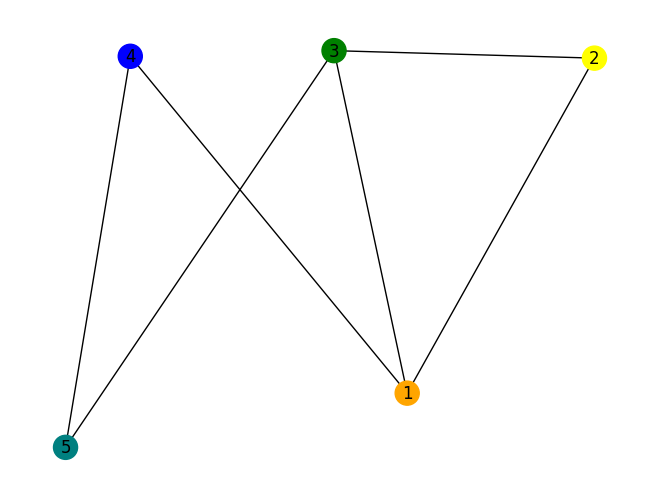

In [80]:
def draw_graph_colors(G):
    colors = nx.get_node_attributes(G, "color") 
    color_map = []
    for node in G.nodes:
        color_map.append(f"{colors[node]}")
    nx.draw(G, node_color=color_map, with_labels=True)
    plt.show()

draw_graph_colors(G1)

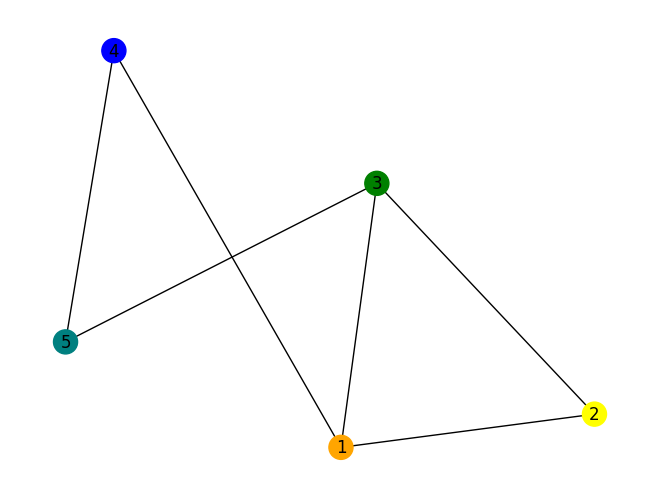

In [81]:
draw_graph_colors(G2)

In [82]:
nx_graphs = [G1, G2]

graphs = graph_from_networkx(nx_graphs, node_labels_tag='color')

gk = GraphKernel(kernel=[{"name": "shortest_path"}], normalize=True)
K = gk.fit_transform(graphs)

print(K)

[[1. 1.]
 [1. 1.]]


In [83]:
# 2.3. Using pyramid match graph kernel to compare 2 above graphs.
graphs = graph_from_networkx(nx_graphs, node_labels_tag='color')

gk = GraphKernel(kernel=[{"name": "pyramid_match"}], normalize=True)
K = gk.fit_transform(graphs)

print(K)

[[1. 1.]
 [1. 1.]]


In [84]:
# 2.4. Using VF2 to compare 2 above graphs.
# Mapping 2 graph G1 and G2
GM = isomorphism.GraphMatcher(G1,G2)
print(f" Checking graph isomorphic: {GM.is_isomorphic()}")
GM.mapping

 Checking graph isomorphic: True


{1: 3, 3: 1, 2: 2, 4: 5, 5: 4}

In [85]:
# 2.5. Using VF2++ to compare 2 above graphs.
check_isomorphic = nx.vf2pp_is_isomorphic(G1, G2, node_label="color")
print(f" Checking graph isomorphic: {check_isomorphic}")

# Mapping 2 graph G1 and G2
nx.vf2pp_isomorphism(G1, G2, node_label="color")

 Checking graph isomorphic: True


{1: 1, 3: 3, 2: 2, 4: 4, 5: 5}